In [1]:
# ! mkdir -p /root/.pip

In [2]:
! /mnt/utils/setup.sh

ln: failed to create symbolic link '/tf/backup/backup': File exists
ln: failed to create symbolic link '/tf/submission/submission': File exists


In [3]:
%%writefile /root/.pip/pip.conf
[global]
index-url=http://ftp.daumkakao.com/pypi/simple
trusted-host=ftp.daumkakao.com

Overwriting /root/.pip/pip.conf


In [1]:
import time
import datetime
import os
import ast
import sys
import pytz
import random
import shutil
# import splitfolders
import copy
from glob import glob
from tqdm import tqdm
from pprint import pprint

import warnings
import requests

import gc
import math
import numpy as np
import pandas as pd

import cv2
from PIL import Image
# import pydicom as pdm
import pickle
import yaml
import h5py
import json
import matplotlib.pyplot as plt
# import seaborn as sns

import albumentations as albu
import torch
import torch.nn as nn
# import torchtuples as tt
from sklearn import metrics

import torchvision
import timm 
# import pretrainedmodels

In [2]:
!pip install timm

Looking in indexes: http://ftp.daumkakao.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
    
print('Using PyTorchversion:', torch.__version__, 'Device:', DEVICE)

Using PyTorchversion: 1.10.0+cu113 Device: cuda


In [4]:
DATA_DIR = '/ainode/dataset/train/'
case_lst = [path.split('/')[-1].split('_')[0] for path in glob(DATA_DIR+'flow/*')]
case_lst.sort()

In [5]:
p_annot_df = pd.read_csv(f'./DATA/annot.csv')
p_annot_df['ID'] = list(range(len(p_annot_df)))
p_annot_df.head()

,Event_Number,Event_Label,Start_Time,End_Time,Start_Epoch,End_Epoch,Duration(second),FPS,Frames,Case,ID
0,0,Wake,2020/05/02 22:20:30.000,2020/05/02 22:21:00.000,1,2,30.0,5.0,"[0, 150]",A2020-EM-01-0001,0
1,4,Wake,2020/05/02 22:21:00.000,2020/05/02 22:21:30.000,2,3,30.0,5.0,"[150, 300]",A2020-EM-01-0001,1
2,5,Wake,2020/05/02 22:21:30.000,2020/05/02 22:22:00.000,3,4,30.0,5.0,"[300, 450]",A2020-EM-01-0001,2
3,7,Wake,2020/05/02 22:22:00.000,2020/05/02 22:22:30.000,4,5,30.0,5.0,"[450, 600]",A2020-EM-01-0001,3
4,8,Wake,2020/05/02 22:22:30.000,2020/05/02 22:23:00.000,5,6,30.0,5.0,"[600, 750]",A2020-EM-01-0001,4


In [7]:
IMG_DIR = '/ainode/dataset/train/'
FLOW_DIR = '/ainode/dataset/train/flow/'
RGB_DIR = '/ainode/dataset/train/rgb/'

In [8]:
p_annot_df['Event_Label'].iloc[1200:2200].value_counts()

Light Sleep    609
Deep Sleep     245
Wake           146
Name: Event_Label, dtype: int64

## Train Val Test Split

In [9]:
cases = set([path.split('/')[-1].split('_')[0] for path in glob('./average_images33/*')])
cases = list(cases)

In [10]:
cases[:5]

['A2021-EM-01-0080',
 'A2020-EM-01-0003',
 'A2020-EM-01-0049',
 'A2021-EM-01-0117',
 'A2020-EM-01-0061']

In [11]:
traincases = cases[:35]
valcases = cases[35:41]
testcases = cases[41:47]

In [12]:
import sklearn

In [13]:
X_train, X_val, X_test = traincases, valcases, testcases

le = sklearn.preprocessing.LabelEncoder()

y_train = []
for case in traincases:
    y_train.append(le.fit_transform(p_annot_df[p_annot_df['Case']==case]['Event_Label'].tolist()))
    
y_val = []
for case in valcases:
    y_val.append(le.fit_transform(p_annot_df[p_annot_df['Case']==case]['Event_Label'].tolist()))
    
y_test = []
for case in testcases:
    y_test.append(le.fit_transform(p_annot_df[p_annot_df['Case']==case]['Event_Label'].tolist()))

In [14]:
np.unique(y_train[0], return_counts=True),\
np.unique(y_val[0], return_counts=True),\
np.unique(y_test[0], return_counts=True)

((array([0, 1, 2]), array([313, 321, 148])),
 (array([0, 1, 2]), array([138, 321, 349])),
 (array([0, 1, 2]), array([238, 498, 101])))

## DataLoader

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import sklearn

In [16]:
import torchvision.transforms as transforms

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
class Dataset(BaseDataset):
    
    def __init__(
            self,  
            X,
            y,
            imgtype, # 'rgb','flow_x','flow_y'
            augmentation=None, 
            preprocessing=None,
    ):
        self.cases = X
        self.imgtype = imgtype
        self.levels = y
        self.labels = [2,1,0]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        case = self.cases[i]
        imgs_path = f'./average_images33/{case}_'
        img_lst = glob(imgs_path+'*.jpg')
        img_lst = sorted(img_lst, key=lambda img: img.split('_')[-1].split('.')[0].zfill(4))
        
        images = []
        
        for idx, path in enumerate(img_lst):
            image = np.array(Image.open(path).resize((128,128)))
            image = np.transpose(image, (2, 1, 0))
            images.append(image)

        images = np.array(images)
#         images = np.transpose(images, (1,0,2,3))
        images = torch.Tensor(images)
        
        level = torch.as_tensor(self.levels[i])
#         level = F.one_hot(level, num_classes=3)
        
        
#         target = np.full(shape=len(level), fill_value = 1, dtype = np.int)
#         target = target[:,np.newaxis]
#         target = torch.Tensor(target)
        
#         label = torch.as_tensor(self.labels)

#         if self.preprocessing:
#             sample = self.preprocessing(images = images)
#             images = sample['images']
        
        return images, level #, label

        
    def __len__(self):
        return len(self.cases)

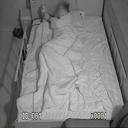

In [19]:
dataset = Dataset(X_train, y_train, 'rgb')
#                   augmentation = get_validation_augmentation()) #, preprocessing = get_preprocessing())
# dataset.levels

image, level = dataset[0] #, label

# np.array(image[0]).shape
# dataset.cases, dataset.epochs
# np.unique(np.array(images[6]))
# Image.fromarray(np.array(image).astype('uint8'))
Image.fromarray(np.transpose(np.array(image[0]).astype('uint8')))
# image.shape #torch.Size([600, 3, 128, 128])
# target.shape #torch.Size([600])
# level.shape #torch.Size([600,3])

In [20]:
BATCH_SIZE = 1

In [21]:
imagetype = 'rgb' # 'rgb', 'flow_x','flow_y'
labels = ['Wake', 'Light Sleep','Deep Sleep']
train_dataset = Dataset(X_train, y_train, imagetype, labels)
val_dataset = Dataset(X_val, y_val, imagetype, labels)
test_dataset = Dataset(X_test, y_test, imagetype, labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset)

In [22]:
print(len(train_loader))

Xtrain, ytrain = next(iter(train_loader))
print('Xtrain:', Xtrain.size(), 'type:', Xtrain.type())
# print('ttrain:', ttrain.size(), 'type:', ttrain.type())
print('ytrain:', ytrain.size(), 'type:', ytrain.type())

print()
print(len(val_loader))

Xval, yval = next(iter(val_loader))
print('Xval:', Xval.size(), 'type:', Xval.type())
# print('tval:', tval.size(), 'type:', tval.type())
print('yval:', yval.size(), 'type:', yval.type())

print()
print(len(test_loader))

Xtest, ytest = next(iter(test_loader))
print('Xtest:', Xtest.size(), 'type:', Xtest.type())
# print('ttest:', ttest.size(), 'type:', ttest.type())
print('ytest:', ytest.size(), 'type:', ytest.type())

35
Xtrain: torch.Size([1, 942, 3, 128, 128]) type: torch.FloatTensor
ytrain: torch.Size([1, 942]) type: torch.LongTensor

6
Xval: torch.Size([1, 857, 3, 128, 128]) type: torch.FloatTensor
yval: torch.Size([1, 857]) type: torch.LongTensor

6
Xtest: torch.Size([1, 861, 3, 128, 128]) type: torch.FloatTensor
ytest: torch.Size([1, 861]) type: torch.LongTensor


In [23]:
%%time
Xtrain, ytrain= next(iter(train_loader)) #, ltrain 

CPU times: user 6.27 ms, sys: 115 ms, total: 122 ms
Wall time: 2.33 s


In [24]:
ytrain

tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
         2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
         1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2

In [25]:
# pltsize = 4                         

# plt.figure(figsize=(10 * pltsize, pltsize))
# for i in range(len(Xtrain[:10])):
#     plt.subplot(1, 10, i+1)
#     plt.axis('off')
#     img = np.transpose(Xtrain.numpy()[i][:,0,:,:], (2,1,0))[:,:,0]
#     plt.imshow(img,cmap="gray_r")
# #     plt.title('Class: ' + str(y_train[i].item()))
#     plt.title('Class: ' + str(ytrain[i])[-2])

## Train Model

In [26]:
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in indexes: http://ftp.daumkakao.com/pypi/simple
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [27]:
!ls /usr/local/lib/python3.8/dist-packages/torchvision/models/

__init__.py  detection		    mnasnet.py	    regnet.py	     vgg.py
__pycache__  efficientnet.py	    mobilenet.py    resnet.py	     video
_utils.py    feature_extraction.py  mobilenetv2.py  segmentation
alexnet.py   googlenet.py	    mobilenetv3.py  shufflenetv2.py
densenet.py  inception.py	    quantization    squeezenet.py


In [28]:
# shutil.move('./efficientnet.py', '/usr/local/lib/python3.8/dist-packages/torchvision/models/')

In [29]:
class efficientnetb0:
    model_name="efficientnetb0"
    batch_size = 16
    WORKERS = 4
    classes = 9
    epochs = 30
    optimizer = "torch.optim.AdamW"
    optimizer_parm = {'lr':1e-3,'weight_decay':0.00001}
    scheduler = "torch.optim.lr_scheduler.CosineAnnealingLR"
    scheduler_parm = {'T_max':5500,'eta_min':0.000001}
    loss_fn = 'torch.nn.CrossEntropyLoss'
    MODEL_PATH = 'log/cpt'
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

In [30]:
model_config = efficientnetb0

In [31]:
from torchvision.models import efficientnet

In [32]:
from efficientnet_pytorch import EfficientNet
# cnn = torchvision.models.densenet121(pretrained = True)
cnn = torchvision.models.efficientnet_b0(pretrained=True).cuda()

num_ftrs = cnn.classifier[1].in_features
cnn.classifier[1] = nn.Linear(num_ftrs,3)
cnn.classifier[1] = nn.Sequential(cnn.classifier[1], nn.Softmax(),)

cnn = torch.nn.DataParallel(cnn)
cnn

DataParallel(
  (module): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activ

In [33]:
!df -h

Filesystem                          Size  Used Avail Use% Mounted on
overlay                              80G   30G   51G  38% /
tmpfs                                64M     0   64M   0% /dev
tmpfs                                94G     0   94G   0% /sys/fs/cgroup
/dev/nvme0n1p1                       80G   30G   51G  38% /mnt
/efs/team/378/backup                8.0E  2.9T  8.0E   1% /mnt/backup
/efs/team/378/submission/submitted  8.0E  2.9T  8.0E   1% /mnt/submission/submitted
/efs/team/378/submission/submit     8.0E  2.9T  8.0E   1% /mnt/submission/submit
/efs/dataset/9                      8.0E  2.9T  8.0E   1% /mnt/dataset
tmpfs                                94G  338M   93G   1% /dev/shm
/dev/nvme3n1                        3.0T  1.4T  1.6T  47% /ainode/dataset
tmpfs                                94G   12K   94G   1% /run/secrets/kubernetes.io/serviceaccount
tmpfs                                94G   12K   94G   1% /proc/driver/nvidia
devtmpfs                             94G     0 

In [34]:
from torch import nn
from torch.nn import functional as F

class NeuralNet(nn.Module):
    def __init__(self,cnn, embed_size=1280, LSTM_UNITS=64, DO = 0.3):
        super(NeuralNet, self).__init__()
        self.cnn = cnn.module
        self.cnn.eval().cuda()
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)

#         self.linear_pe = nn.Linear(LSTM_UNITS*2, 1)
        self.linear_global = nn.Linear(LSTM_UNITS*2, 3)

    def forward(self, x, lengths=None):
        with torch.no_grad():
            embedding = self.cnn.features(x) #extract_features(x)
            embedding = self.avgpool(embedding)
            b,f,_,_ = embedding.shape
            embedding = embedding.reshape(1,b,f)
        self.lstm1.flatten_parameters()
        h_lstm1, _ = self.lstm1(embedding)
        self.lstm2.flatten_parameters()
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = F.relu(self.linear1(h_lstm1))
        h_conc_linear2  = F.relu(self.linear2(h_lstm2))
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2

#         output = self.linear_pe(hidden)
#         print("shape of hidden:", hidden.shape)
    
        hid = torch.unsqueeze(hidden[0][0],0)
        out = self.linear_global(hid)
        output_global = out
        
        for hid in hidden[0][1:]:
#             print('hid.shape:',hid.shape)
            hid = torch.unsqueeze(hid, 0)
            out = self.linear_global(hid)
            output_global = torch.cat((output_global, out), 0)
            
        output_global = torch.unsqueeze(output_global,0)
            
#         print('룰루')
#         print(output_global.shape)
#         output_global = torch.Tensor(output_global)
    
        return output_global

In [35]:
model = NeuralNet(cnn).cuda()

In [36]:
optimizer = eval(model_config.optimizer)(model.parameters(),**model_config.optimizer_parm)
scheduler = eval(model_config.scheduler)(optimizer,**model_config.scheduler_parm)
loss_fn = eval(model_config.loss_fn)()#pos_weight=torch.FloatTensor(model_config.pos_weight).cuda())

In [37]:
model

NeuralNet(
  (cnn): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation)

In [38]:
criterion = nn.CrossEntropyLoss()

In [39]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [40]:
import torch
import numpy as np
from tqdm.auto import tqdm
import os
class trainer:
    def __init__(self,loss_fn,model,optimizer,scheduler,config):
        self.loss_fn = loss_fn
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.config = config

        
    def batch_train(self, batch_imgs, batch_labels):
        imgs = batch_imgs.to(DEVICE)
        labels = batch_labels.to(DEVICE)
        self.optimizer.zero_grad()
        predicted = self.model(imgs)
#         predicted = torch.Tensor(predicted)
        loss = 0
        for i in range(len(labels[0])-1):
            loss += criterion(predicted[:,i], labels[:,i])
        loss /= len(labels[0])-1 
        loss.backward()
        self.optimizer.step()
        prediction = predicted.max(1, keepdim=True)[1]
        
#         train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/BATCH_SIZE)
        
        return loss, predicted
    
    def batch_valid(self, batch_imgs,get_fet):
        self.model.eval()
        batch_imgs = batch_imgs.cuda()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
            prediction = []
            for pred in predicted:
                pred = pred.absolute()
                prediction.append(pred.max(1, keepdim=True)[1])
#             predicted[0] = torch.sigmoid(predicted[0])
#             predicted[1] = torch.sigmoid(predicted[1])
#         return prediction
        return prediction, predicted
    
    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
#             print(imgs.shape)
            loss, predicted = self.batch_train(imgs[0], labels)
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(
                    current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step(batch_idx)
#             if batch_idx>10:
#                 break
        return current_loss_mean
    
    def valid_epoch(self, loader,name="valid"):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        correct = 0
        val_loss = AverageMeter()
        val_acc = AverageMeter()
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                imgs = imgs[0].to(DEVICE)
                labels = labels.to(DEVICE)
                predicted = self.model(imgs)
                loss = 0
                for i in range(len(labels[0])-1):
                    loss += criterion(predicted[:,i], labels[:,i])
                loss /= len(labels[0])-1 
                prediction = predicted.max(1, keepdim=True)[1]
                
#                 val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/BATCH_SIZE)
                
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
                tqdm_loader.set_description(f"loss : {current_loss_mean:.4}")
#             if batch_idx>10:
#                 break
        score = 1-current_loss_mean
        print('metric {}'.format(score))
        return score
    
    def run(self,train_loder,val_loder):
        best_score = -100000
        for e in range(self.config.epochs):
            print("----------Epoch {}-----------".format(e))
            current_loss_mean = self.train_epoch(train_loder)
            score = self.valid_epoch(val_loder)
            if best_score < score:
                best_score = score
                torch.save(self.model.state_dict(),self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name))
                print("==================best model saved===================")

    def batch_valid_tta(self, batch_imgs):
        batch_imgs = batch_imgs.cuda()
        predicted = model(batch_imgs)
        tta_flip = [[-1],[-2]]
        for axis in tta_flip:
            predicted += torch.flip(model(torch.flip(batch_imgs, axis)), axis)
        predicted = predicted/(1+len(tta_flip))
        predicted = torch.sigmoid(predicted)
        return predicted.cpu().numpy()
            
    def load_best_model(self):
        if os.path.exists(self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name)):
            self.model.load_state_dict(torch.load(self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name)))
            print("load best model")
        
    def predict(self,imgs_tensor,get_fet = False):
        self.model.eval()
        with torch.no_grad():
            return self.batch_valid(imgs_tensor,get_fet=get_fet)

In [41]:
Trainer = trainer(loss_fn,model,optimizer,scheduler,config=model_config)

In [42]:
train = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=model_config.WORKERS, pin_memory=False)
val = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=model_config.WORKERS, pin_memory=False)

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
Trainer.run(train,val)

----------Epoch 0-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.01955437660217285
==================best model saved===================
----------Epoch 1-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.006775498390197754
==================best model saved===================
----------Epoch 2-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.006103396415710449
==================best model saved===================
----------Epoch 3-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.006200313568115234
----------Epoch 4-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.00622868537902832
----------Epoch 5-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.006157636642456055
----------Epoch 6-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea20cdf280>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea20cdf280>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProce

metric -0.005975604057312012
==================best model saved===================
----------Epoch 7-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.006007671356201172
----------Epoch 8-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.006193995475769043
----------Epoch 9-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea20cdf280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea20cdf280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

metric -0.0062988996505737305
----------Epoch 10-----------


  0%|          | 0/35 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea20cdf280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea20cdf280>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea20cdf280>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.006216883659362793
----------Epoch 11-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.00610959529876709
----------Epoch 12-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.0061533451080322266
----------Epoch 13-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.0060929059982299805
----------Epoch 14-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.006121158599853516
----------Epoch 15-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

metric -0.006032705307006836
----------Epoch 16-----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
!nvidia-smi

In [44]:
Trainer.load_best_model()

load best model


In [45]:
test = DataLoader(test_dataset)

inference = []
for image, level in tqdm(test):
    inference.append(Trainer.predict(image[0]))

  0%|          | 0/6 [00:00<?, ?it/s]

In [46]:
list(inference[0][1][0])[:]

[tensor([-0.2234,  0.4962, -0.2866], device='cuda:0'),
 tensor([-0.2294,  0.5237, -0.2962], device='cuda:0'),
 tensor([-0.2345,  0.5381, -0.3015], device='cuda:0'),
 tensor([-0.2382,  0.5461, -0.3046], device='cuda:0'),
 tensor([-0.2406,  0.5506, -0.3063], device='cuda:0'),
 tensor([-0.2421,  0.5531, -0.3073], device='cuda:0'),
 tensor([-0.2430,  0.5545, -0.3078], device='cuda:0'),
 tensor([-0.2434,  0.5553, -0.3081], device='cuda:0'),
 tensor([-0.2437,  0.5557, -0.3083], device='cuda:0'),
 tensor([-0.2439,  0.5559, -0.3083], device='cuda:0'),
 tensor([-0.2439,  0.5560, -0.3084], device='cuda:0'),
 tensor([-0.2440,  0.5560, -0.3084], device='cuda:0'),
 tensor([-0.2440,  0.5561, -0.3084], device='cuda:0'),
 tensor([-0.2440,  0.5561, -0.3084], device='cuda:0'),
 tensor([-0.2440,  0.5561, -0.3084], device='cuda:0'),
 tensor([-0.2440,  0.5561, -0.3084], device='cuda:0'),
 tensor([-0.2440,  0.5561, -0.3084], device='cuda:0'),
 tensor([-0.2440,  0.5561, -0.3084], device='cuda:0'),
 tensor([-

In [49]:
inference[0][0]

[tensor([[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
      

In [47]:
inference[1][0].size()

AttributeError: 'list' object has no attribute 'size'

In [ ]:
torch.unique(inference[2][0])

# Save Model

In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
import os
class trainer:
    def __init__(self,loss_fn,model,optimizer,scheduler,config):
        self.loss_fn = loss_fn
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.config = config

        
    def batch_train(self, batch_imgs, batch_labels0, batch_idx): #,batch_labels1
        batch_imgs, batch_labels0 = batch_imgs.cuda().float(), batch_labels0.cuda().float() #,batch_labels1 = ,batch_labels1.cuda().floa
        predicted = self.model(batch_imgs)
        loss1 = self.loss_fn(predicted.float().reshape(-1), batch_labels0.reshape(-1))
#         loss2 = self.loss_fn(predicted[1].float().reshape(-1), batch_labels1.reshape(-1))
        loss = loss1 #+loss2
#         loss = loss/2.0
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item(), predicted
    
    def batch_valid(self, batch_imgs,get_fet):
        self.model.eval()
        batch_imgs = batch_imgs.cuda()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
            print(predicted)
#             predicted[0] = torch.sigmoid(predicted[0])
#             predicted[1] = torch.sigmoid(predicted[1])
#             prediction = np.array(predicted).max(0) #, keepdim = True)[1] 
        return prediction
    
    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader): #,labels1)
            loss, predicted = self.batch_train(imgs[0], labels, batch_idx) #labels1
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(
                    current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step(batch_idx)
            if batch_idx>10:
                break
        return current_loss_mean
    
    def valid_epoch(self, loader,name="valid"):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        correct = 0
        for batch_idx, (imgs,labels0) in enumerate(tqdm_loader): #,labels1)
            with torch.no_grad():
                batch_imgs = imgs.cuda().float()[0]
                batch_labels0 = labels0.cuda().float()
#                 batch_labels1 = labels1.cuda().float()
                predicted = self.model(batch_imgs)
                loss0 = self.loss_fn(predicted.float().reshape(-1),batch_labels0.float().reshape(-1)).item()
#                 loss1 = self.loss_fn(predicted[1].float().reshape(-1),batch_labels1.float().reshape(-1)).item()
                loss = loss0 #+ loss1
#                 loss = loss/2.0
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
                tqdm_loader.set_description(f"loss : {current_loss_mean:.4}")
            if batch_idx>10:
                break
        score = 1-current_loss_mean
        print('metric {}'.format(score))
        return score
    
    def run(self,train_loder,val_loder):
        best_score = -100000
        for e in range(self.config.epochs):
            print("----------Epoch {}-----------".format(e))
            current_loss_mean = self.train_epoch(train_loder)
            score = self.valid_epoch(val_loder)
            if best_score < score:
                best_score = score
                torch.save(self.model.state_dict(),self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name))

    def batch_valid_tta(self, batch_imgs):
        batch_imgs = batch_imgs.cuda()
        predicted = model(batch_imgs)
        tta_flip = [[-1],[-2]]
        for axis in tta_flip:
            predicted += torch.flip(model(torch.flip(batch_imgs, axis)), axis)
        predicted = predicted/(1+len(tta_flip))
        predicted = torch.sigmoid(predicted)
        return predicted.cpu().numpy()
            
    def load_best_model(self,):
        if os.path.exists(self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name)):
            self.model.load_state_dict(torch.load(self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name)))
            print("load best model")
        
    def predict(self,imgs_tensor,get_fet = False):
        self.model.eval()
        with torch.no_grad():
            return self.batch_valid(imgs_tensor,get_fet=get_fet)

In [ ]:
Trainer = trainer(loss_fn,model,optimizer,scheduler,config=model_config)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=model_config.WORKERS, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=model_config.WORKERS, pin_memory=False)

In [ ]:
Trainer.run(train_loader,val_loader)

In [ ]:
!mkdir ./saved-models-averagecnnlstm/

In [ ]:
mymodel = trainer(loss_fn,model,optimizer,scheduler,config=model_config)
mymodel.load_best_model()

In [ ]:
image, level= next(iter(test_loader))

In [ ]:
type(image[:,0,:,:])

In [ ]:
# https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
# this function is used during training process, to calculation the loss and accuracy

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
image, label = next(iter(train_loader))
image.shape, label.shape

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()                                                 # assign train mode to the model
    
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()                                     # 과거에 이용한 Mini-Batch내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient값이 optimizer에 할당되어 있으므로 optimizer의 Gradient 초기화
        output = model(image)
        loss = criterion(output, label)
        loss.backward()                                           # Back propagation으로 계산된 Gradient 값을 각 parameter에 할당
        optimizer.step()                                          # parameter update
        scheduler.step()
        prediction = output.max(1, keepdim = True)[1]             # predicted labels in tensor
        
        train_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
        train_loss.update(loss.item())
        
        if batch_idx % log_interval == 0:                         # print log
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
    
    total_loss_train.append(train_loss.avg)
    total_acc_train.append(train_acc.avg)

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    
    with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            loss = criterion(output, label)
            prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
    
            val_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
            val_loss.update(loss.item())
    
    total_acc_val.append(val_acc.avg)
    total_loss_val.append(val_loss.avg)
    
    return val_loss.avg, val_acc.avg   

In [ ]:
best_val_acc = 0
best_val_loss = 100
epoch = 0
total_loss_train, total_acc_train = [],[]
total_loss_val, total_acc_val = [],[]

for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 20)
    val_loss, val_acc = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tVal Loss: {:.4f}, \tVal Accuracy: {:.2f} %\n".format(Epoch, val_loss, val_acc))
    
    # monitoring test accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epoch = Epoch
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, val_loss, val_acc))
        print('*****************************************************')
    elif Epoch > epoch + TRAIN_PATIENCE:
        break
        
#     # monitoring test loss
#     if test_loss < best_val_loss:
#         best_val_loss = test_loss
#         epoch = Epoch
#         print('*****************************************************')
#         print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, test_loss, test_accuracy))
#         print('*****************************************************')
#     elif Epoch > epoch + TRAIN_PATIENCE:
#         break

In [ ]:
best_val_acc

# Evaluation

In [ ]:
min(total_loss_val), max(total_acc_val)

In [ ]:
Trainer.load_best_model()
Trainer.predict(image[:,0,:,:])

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_loss_val, label = 'test loss')
fig2.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_acc_val, label = 'test accuracy')
plt.legend()
plt.show()

In [ ]:
image[:,0,:,:].shape

In [ ]:
resnet3d = torchvision.models.video.r3d_18(pretrained = True, progress = True)

In [ ]:
# classifier layer output shape --> number of classes
CLASSES = 3

num_ftrs = resnet3d.fc.in_features
resnet3d.fc = nn.Linear(num_ftrs,CLASSES)
resnet3d.fc = nn.Sequential(resnet3d.fc, nn.Softmax(),)

In [ ]:
mymodel.predict(image)

In [ ]:
# best_model = resnet3d.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
model.predict(test_dataset[3][0])

In [ ]:
predicted

In [ ]:
best_model = resnet3d

In [ ]:
WORK_DIR = './'

In [ ]:
DIR = WORK_DIR + 'saved-models/'

weights = os.listdir(DIR)
weights.sort()
# val_losses = [filename.split('-')[2].split('val')[1] for filename in weights]
val_losses = [filename.split('-')[2].split('val')[1] for filename in weights] #[1:]]
best_weight = val_losses.index(min(val_losses))
# path = './saved_models/' + weights[best_weight]
path = DIR + weights[best_weight] #+1] # '.ipynb_checkpoints' 파일이 맨 앞에 있기 때문에 index가 하나씩 밀린다.

# best_model = torch.load(DIR+'model-epoch00-loss_val1.08-acc_val0.46.pt')
checkpoint = torch.load(path)
best_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
# loss = checkpoint['loss']

best_model.eval()

# Inference

In [ ]:
!ls /mnt/dataset/test/annotation

In [ ]:
!ls /ainode/dataset/test/flow

In [ ]:
!ls /ainode/dataset/test/rgb

# Evaluate Model

In [ ]:
true_labels = []
predicted_labels = []
predicted_values = []

# best_model.eval()
    
test_loss = AverageMeter()
test_acc = AverageMeter()

with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
    for image, label in test_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = best_model(image)
        loss = criterion(output, label)
        prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
        
        true_labels.append(label)
        predicted_labels.append(prediction)
        predicted_values.append(output)
        
        test_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
        test_loss.update(loss.item())
        
test_loss.avg, test_acc.avg

In [ ]:
len(predicted_values)

In [ ]:
# tensor to array form
true_test_lst = []
predicted_test_lst = []
predicted_value_lst = []

for i in range(len(test_loader)):
    t_labels = true_labels[i].cpu().numpy()
    true_test_lst += list(t_labels)
    
    p_labels = predicted_labels[i].cpu().numpy()[:,0]
    predicted_test_lst += list(p_labels)
    
    p_values = predicted_values[i].cpu().numpy()
    predicted_value_lst += list(p_values)
    
true_test_arr = np.array(true_test_lst)
predicted_test_arr = np.array(predicted_test_lst)
predicted_value_arr = np.array([list(arr) for arr in predicted_value_lst])
    
true_test_arr[:20], predicted_test_arr[:20], predicted_value_arr[:20]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [ ]:
# Confusion Matrix
tick_labels = ['Wake', 'Light Sleep','Deep Sleep']

cm = confusion_matrix(true_test_arr, predicted_test_arr)
ax = sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

In [ ]:
# Classification Report

labels = ['Wake', 'Light Sleep','Deep Sleep']

print(classification_report(true_test_arr, predicted_test_arr, target_names = labels))

In [ ]:
# roc curve for classes

fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(true_test_arr == i, predicted_value_arr[:, i])
    
# plotting
plt.plot(fpr[1], tpr[1], linestyle='--',color='blue', label='Positive: Opacity / Negative: Normal') # Sensitivity: 비정상 중에 비정상으로 predict된 비율 / Specificity: 정상 중에 정상으로 predict된 비율
plt.title('ROC curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='best') 